Automatically analyse all data-files in a dataset
=======

Import the required bits.

In [9]:
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
import mindaffectBCI.decoder.offline.datasets as datasets
from mindaffectBCI.decoder.decodingCurveSupervised import decodingCurveSupervised, print_decoding_curve, plot_decoding_curve
from mindaffectBCI.decoder.analyse_datasets import decoding_curve_GridSearchCV, datasets_decoding_curve_GridSearchCV, average_results_per_config, plot_decoding_curves
from mindaffectBCI.decoder.preprocess_transforms import make_preprocess_pipeline, ClassAveragePlotter
from mindaffectBCI.decoder.utils import askloadsavefile

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 8] # bigger default figures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Analyse all datafiles in a single dataset with given analysis settings
-----


### Tell the system the directory where the datasets directory is located

In [7]:
# tell the system where the data is stored..
#datasets.add_dataroot('')
datasets.set_dataroot('G:/Shared drives/Data/experiments/BCI_speller/online_bci/s8/')
datasets.get_dataroot()

'G:/Shared drives/Data/experiments/BCI_speller/online_bci/s8/'

## set the dataset you want and get the list of files in it.
* `dataset` is parent directory name, relative to dataroot, to search for datasets
* `label` is human readable label for this dataset+analysis for plots etc.

In [4]:
# Lowlands
dataset='lowlands'
dataset_args=dict()
label='lowlands'

In [5]:
# plos_one
dataset='plos_one'
dataset_args=dict()
label='plos_one'

In [6]:
# ask for a directory to load
dataset='mindaffectBCI'
dataset_args=dict(exptdir=askloadsavefile(filetypes='dir'))

## get the list of datasets and the loader object

In [10]:
loader,filenames,_ = datasets.get_dataset(dataset, **dataset_args)
cp = os.path.commonprefix(filenames)
labels = [ p[len(cp):] for p in filenames ]
print("{} has {} files\n{}".format(dataset,len(filenames),"\n".join(labels)))

mindaffectBCI has 10 files
825_1630\mindaffectBCI_online_bci_220825_1630.txt
825_1517\mindaffectBCI_online_bci_220825_1517.txt
825_1639\mindaffectBCI_online_bci_220825_1639.txt
901_1243\mindaffectBCI_online_bci_220901_1244.txt
901_1142\mindaffectBCI_online_bci_220901_1142.txt
901_1059\mindaffectBCI_online_bci_220901_1059.txt
901_1046\mindaffectBCI_online_bci_220901_1047.txt
901_1040\mindaffectBCI_online_bci_220901_1041.txt
831_1958\mindaffectBCI_online_bci_220831_1958.txt
831_1929\mindaffectBCI_online_bci_220831_1929.txt


## Fit model to each of the datasets

## Specify the analysis pipeline you want to use.
The pipeline is given as a list of 'stages' which will be processed in turn by calling the appropriate class's `fit` and `modify` methods.   See `decoder/preprocess_transforms.py` for a list of available transforms.

Here we use:
  * `MetaInfoAdder` : to attach important meta-info, specifically the data samplerate and the list of channel names. 
  * `ButterFilterAndResampler` : To use a 'butterworth' IIR filter to first spectrally filter the data and then downsample it to a new sample rate
  * `MultiCCA` : This is the Cannonical Correlation Analysis based Sequence2Sequence classifier we use for the analysis.  For more information on the available Sequence2Sequence classifiers available see `decoder/model_fitting.py`


In [11]:
# Single Cell version: all fixed!

# default pipeline
fs_out = 180
loader_args={'fs_out':fs_out,'filterband':((0,1),(45,65),(95,105),(145,155),(195,205))}#,'sample2timestamp':'lower_bound_tracker'}#'robust_timestamp_regression'}# 
pipeline=[
    ['MetaInfoAdder',{'info':{'fs':-1}}],
    ['ButterFilterAndResampler',{'filterband':[(3,25,'bandpass')], 'fs_out':fs_out}],
    #['TargetEncoder',{'evtlabs':('re','fe')}],
    ['MultiCCACV:clsfr',{'tau_ms':450, 'offset_ms':0,'evtlabs':('onset','offset'), 'temporal_basis':'fourier2,8'}], #
    #['BwdLinearRegressionCV:clsfr',{"tau_ms":450, "inner_cv_params":{"reg":(1e-4, 1e-3, .01, .1, .5, 1-.1, 1-.01)}}]
    #['MultiCCA:clsfr',{'tau_ms':450, 'offset_ms':0}]
]
ppp = make_preprocess_pipeline(pipeline)
print(ppp)

PreprocessPipeline(stages=[('metainfoadder', MetaInfoAdder(info={'fs': -1})),
                           ('butterfilterandresampler',
                            ButterFilterAndResampler(filterband=[(3, 25,
                                                                  'bandpass')],
                                                     fs_out=180)),
                           ('clsfr',
                            MultiCCACV(evtlabs=('onset', 'offset'), tau_ms=450,
                                       temporal_basis='fourier2,8'))])


## Test: run a single dataset with this pipeline
By:
1. Loading the data
2. Visualizing the data, via. and ERP plot
2. Making the analysis pipeline
3. Fit the pipeline to the data
4. Assessing the fitted model quality

Note: you can access the created or fitted data transformation 'stages' through the `stages` property of the created pipeline.

In [12]:
# 1. Load the data, extract meta-info
X_TSd, Y_TSy, coords = loader(filenames[0],**loader_args)
fs=coords[1]['fs']
ch_names=coords[2]['coords']


Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot


EventRelatedPotentialPlotter(fig=<Figure size 864x576 with 16 Axes>, tau_ms=600)

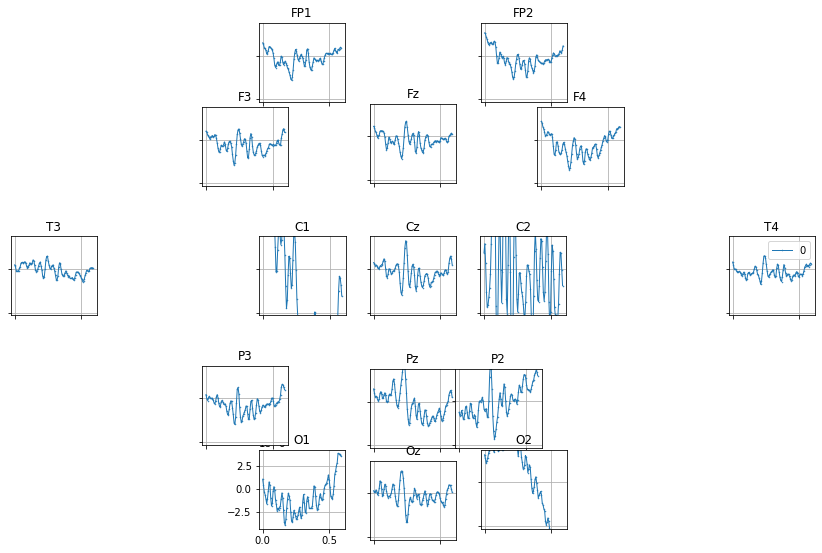

In [13]:
# plot the average response when the stimulus is high, to give idea of the signal2noise
ClassAveragePlotter(tau_ms=600).fit(X_TSd, Y_TSy, fs=fs, ch_names=ch_names)

     -> best={},1 = 0.642
 Retraining on all data with: rank=1 reg=(1e-08, 1e-08)


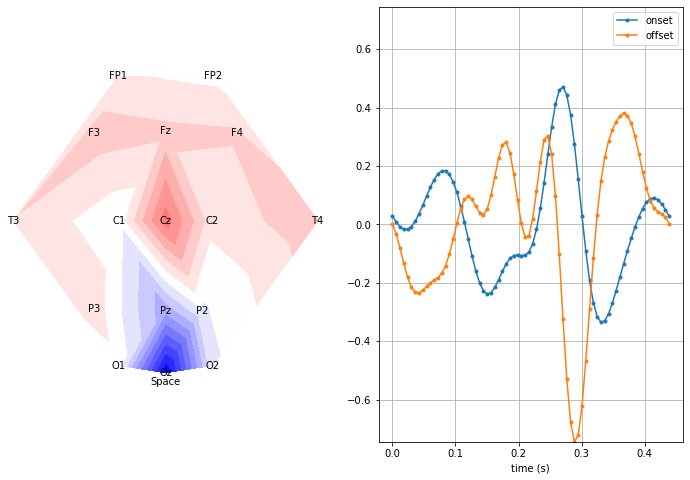

In [14]:
# 2. Make the analysis pipeline -- after updating the metainfo adder to reflect the data properties
pipeline[0][1]['info'] = {'fs':fs,'ch_names':ch_names}
ppp = make_preprocess_pipeline(pipeline)
# 3. Fit the pipeline to the data
ppp.fit(X_TSd,Y_TSy)
# 4. plot the fitted classifier model, i.e. last stage
ppp.stages[-1][1].plot_model(fs=fs,ch_names=ch_names)


     -> best={},1 = 0.678
 Retraining on all data with: rank=1 reg=(1e-08, 1e-08)
Int Lens:..............................

            IntLen   310   621   854  1165  1476  1709  2020  2331 
              Perr  0.85  0.45  0.15  0.15  0.10  0.10  0.10  0.10   AUDC 30.2
         Perr(est)  1.00  0.37  0.24  0.12  0.10  0.08  0.08  0.08   PSAE 19.5
           StopErr  0.85  0.45  0.20  0.10  0.10  0.10  0.10  0.10   AUSC 29.8
     StopThresh(P)  0.51  0.22  0.15  0.09  0.09  0.09  0.09  0.09   SSAE 36.6



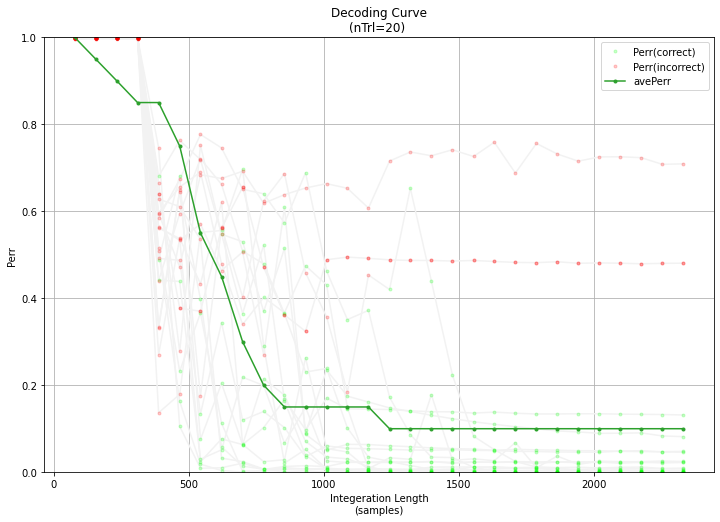

In [15]:
# 4. Assess the fitted model performance.   
#    As we want a cv'd estimate of the classifier performance we do this in 3 stages,
#    a) we apply the fitted model before the classifier to the data
Xpp_TSd, Ypp_TSye = ppp.modify(X_TSd,Y_TSy,until_stage=-1)
#    b) then we cv apply the classifer to get a cv'd classifier prediction
res = ppp.stages[-1][1].cv_fit(Xpp_TSd, Ypp_TSye)
#    c) then we assess the performance of these cv'd predictions
plot_decoding_curve( *decodingCurveSupervised(res['estimator']))

## Now do the same for all data-sets together and collate the results to a final performance

So far we have just run the analysis on a single, previously loaded dataset.  However, to get a real feeling for the importance of different settings, we need to compare them over multiple files recorded at different times for different subjects.  

To make this easier to perform, a equivalent function called `datasets_decoding_curve_GridsearchCV` is provided for running a GridsearchCV over multiple data sets.

To use this function, you must provide a file-loader function and a set of file-names to process, for example as produced as the output of the `get_dataset` call use above.

To run the decoding curve analysis on all the datasets we got above, with the same pipeline we used for the single data-set test.

Running with 4 parallel tasks, one-per-filename
Submitting {} jobs:..........10 jobs submitted in    0s. Waiting results.

10% 1 / 10 collected in  4.6s  est 45.9s total 41.3s remaining
60% 6 / 10 collected in  8.0s  est 13.3s total  5.3s remaining
Ave-DC
            IntLen   301   603   830  1132  1434  1661  1963  2266 
              Perr  0.97  0.57  0.40  0.29  0.23  0.20  0.20  0.20   AUDC 43.3
         Perr(est)  1.00  0.38  0.32  0.22  0.21  0.19  0.19  0.19   PSAE 22.0
           StopErr  0.95  0.95  0.95  0.92  0.76  0.64  0.57  0.57   AUSC 80.7
     StopThresh(P)  0.76  0.76  0.76  0.72  0.58  0.54  0.56  0.56   SSAE 19.8



C:\Users\rohit\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


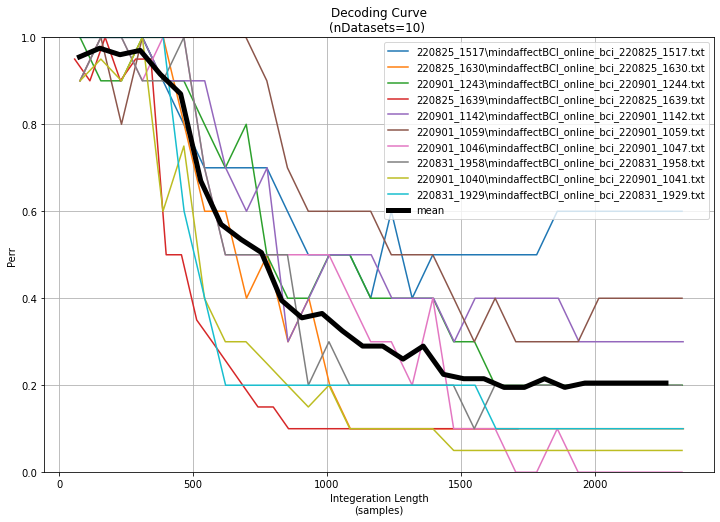

In [16]:
# run the model fit
# first make the base pipeline to run
ppp = make_preprocess_pipeline(pipeline)

# run this pipeline with all the settings.
# N.B. set n_jobs=1 for pipeline debugging as it gives more informative error messages and stops at first error
res = datasets_decoding_curve_GridSearchCV(ppp,filenames, loader, loader_args=loader_args, 
                                           cv=[(slice(10),slice(10,None))], n_jobs=4, 
                                           cv_clsfr_only=False)


print("Ave-DC")
print(print_decoding_curve(*(average_results_per_config(res)['decoding_curve'][0])))

plt.figure()
plot_decoding_curves(res['decoding_curve'],labels=res['filename'])
plt.show(block=True)

This time, the results contains a set of keys with lists as values.  In this case each entry in the value list is a single run _of a particular configuration on a particular file name_.  As we want to see how a config does over all file names we first average over file-name to summarise the results.

In [17]:
# raw results are per run, i.e. combination of filename and configuration
# interested in effect of config, so average over filenames to get a pre-configuration summary
res = average_results_per_config(res)

C:\Users\rohit\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


As we now have 'row-per-config' we can plot the decoding curves as for a single file:

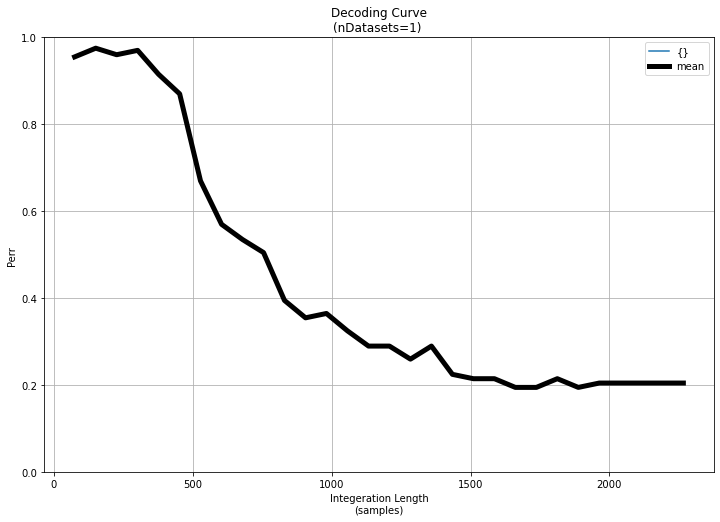



{}

            IntLen   301   603   830  1132  1434  1661  1963  2266 
              Perr  0.97  0.57  0.40  0.29  0.23  0.20  0.20  0.20   AUDC 43.3
         Perr(est)  1.00  0.38  0.32  0.22  0.21  0.19  0.19  0.19   PSAE 22.0
           StopErr  0.95  0.95  0.95  0.92  0.76  0.64  0.57  0.57   AUSC 80.7
     StopThresh(P)  0.76  0.76  0.76  0.72  0.58  0.54  0.56  0.56   SSAE 19.8



In [18]:
plt.figure()
plot_decoding_curves(res['decoding_curve'],labels=res['config'])
plt.show(block=True)

for si in np.argsort(res['audc']):
    dc,conf = (res['decoding_curve'][si],res['config'][si])
    print("\n\n{}\n".format(conf))
    print(print_decoding_curve(*dc))

We can also print the full pre-filename decoding curve information for for through investigation

In [19]:
for r,f in zip(res['decoding_curve'],res['filename']):
    print(f)
    print(print_decoding_curve(*r))

['220825_1517\\mindaffectBCI_online_bci_220825_1517.txt', '220825_1630\\mindaffectBCI_online_bci_220825_1630.txt', '220901_1243\\mindaffectBCI_online_bci_220901_1244.txt', '220825_1639\\mindaffectBCI_online_bci_220825_1639.txt', '220901_1142\\mindaffectBCI_online_bci_220901_1142.txt', '220901_1059\\mindaffectBCI_online_bci_220901_1059.txt', '220901_1046\\mindaffectBCI_online_bci_220901_1047.txt', '220831_1958\\mindaffectBCI_online_bci_220831_1958.txt', '220901_1040\\mindaffectBCI_online_bci_220901_1041.txt', '220831_1929\\mindaffectBCI_online_bci_220831_1929.txt']
            IntLen   301   603   830  1132  1434  1661  1963  2266 
              Perr  0.97  0.57  0.40  0.29  0.23  0.20  0.20  0.20   AUDC 43.3
         Perr(est)  1.00  0.38  0.32  0.22  0.21  0.19  0.19  0.19   PSAE 22.0
           StopErr  0.95  0.95  0.95  0.92  0.76  0.64  0.57  0.57   AUSC 80.7
     StopThresh(P)  0.76  0.76  0.76  0.72  0.58  0.54  0.56  0.56   SSAE 19.8



# Run different parameter settings and compare final performance
Now let's see the effect of varying some of the 'hyperparameters' of the pipeline

specify the `tuned_parameters` grid to evaluate.

**N.B. each field should contain a list of valid parameter settings**

In [20]:
tuned_parameters=dict()
#tuned_parameters['clsfr__evtlabs']=[('re','fe'),('re','fe','anyfe')]
tuned_parameters['clsfr__tau_ms']=[350,450]
#tuned_parameters['clsfr__offset_ms']=[0,100]
tuned_parameters['clsfr__temporal_basis']=['none','winfourier1,10','winfourier2,10','winfourier2,15']

Now run the cross dataset analysis.    **This may take some time**   To speed things up a bit we specify `n_jobs=4` to run 4 analysis in parallel threads. (Note: don't set  `n_jobs` too high as that can cause job failures due to memory constraints.  Also for debugging run with `n_jobs=1` as this gives more informative error messages.)

At the end you will get a textual summary of the results, and the detailed results are returned.

In [21]:
ppp = make_preprocess_pipeline(pipeline)
# run this pipeline with all the settings.
# N.B. set n_jobs=1 for pipeline debugging as it gives more informative error messages and stops at first error
res = datasets_decoding_curve_GridSearchCV(ppp,filenames, loader, loader_args=loader_args, 
                                           cv=[(slice(10),slice(10,None))], n_jobs=4, 
                                           cv_clsfr_only=False, tuned_parameters=tuned_parameters)

Running with 4 parallel tasks, one-per-filename
Submitting {} jobs:..........10 jobs submitted in    0s. Waiting results.

10% 1 / 10 collected in 17.2s  est 171.8s total 154.6s remaining
40% 4 / 10 collected in 21.8s  est 54.4s total 32.6s remaining
50% 5 / 10 collected in 31.1s  est 62.2s total 31.1s remaining
70% 7 / 10 collected in 34.7s  est 49.5s total 14.9s remaining
80% 8 / 10 collected in 41.2s  est 51.5s total 10.3s remaining
90% 9 / 10 collected in 44.4s  est 49.4s total  4.9s remaining


### Visualize the reslts

C:\Users\rohit\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


Ave-DC


{'clsfr__tau_ms': 350, 'clsfr__temporal_basis': 'none'}

            IntLen   301   603   830  1132  1434  1661  1963  2266 
              Perr  0.95  0.54  0.37  0.34  0.23  0.20  0.22  0.22   AUDC 42.7
         Perr(est)  1.00  0.35  0.30  0.24  0.20  0.17  0.16  0.16   PSAE 28.8
           StopErr  0.97  0.97  0.97  0.91  0.72  0.62  0.61  0.61   AUSC 82.3
     StopThresh(P)  0.77  0.77  0.77  0.72  0.58  0.53  0.55  0.55   SSAE 22.5



{'clsfr__tau_ms': 350, 'clsfr__temporal_basis': 'winfourier1,10'}

            IntLen   301   603   830  1132  1434  1661  1963  2266 
              Perr  0.94  0.54  0.40  0.32  0.21  0.20  0.22  0.22   AUDC 42.7
         Perr(est)  1.00  0.35  0.31  0.24  0.20  0.17  0.16  0.16   PSAE 27.6
           StopErr  0.97  0.97  0.97  0.91  0.74  0.64  0.61  0.61   AUSC 82.2
     StopThresh(P)  0.76  0.76  0.76  0.72  0.58  0.54  0.55  0.55   SSAE 22.4



{'clsfr__tau_ms': 350, 'clsfr__temporal_basis': 'winfourier2,10'}

            IntLen   301  

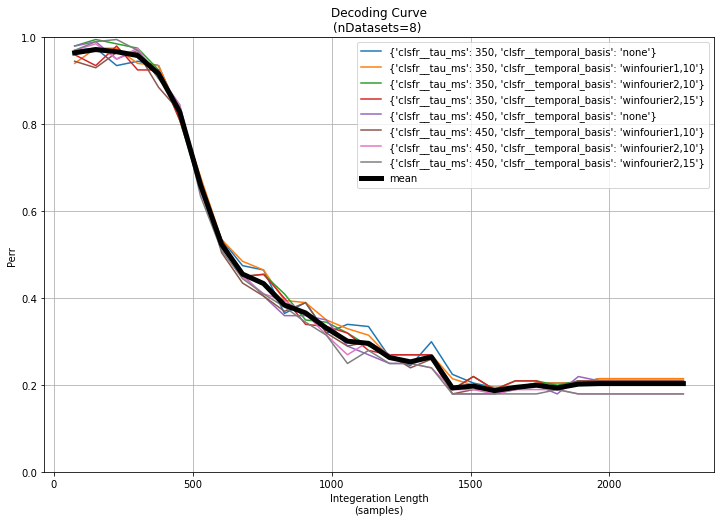

In [22]:
# average the results over data-files for each pipeline configuration
averes = average_results_per_config(res)

print("Ave-DC")
# report the per-config summary
for dc,conf in zip(averes['decoding_curve'],averes['config']):
    print("\n\n{}\n".format(conf))
    print(print_decoding_curve(*dc))

plot_decoding_curves(averes['decoding_curve'],labels=res['config'])
plt.show(block=True)